# Covid Simulation

code: https://github.com/adithyarganesh/CSC555_Covid_Simulation

Created below is an agent based simulation modelling of how a virus can spread in a society during a pandemic. The simulation is created using the MESA library to simulate houses, grocery shops, parks and quarantine centers.
### Source Code
The main libraries used for this simulation are MESA for simulation, Matplotlib for graphs, math and numpy

In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import math
import numpy as np
import matplotlib.pyplot as plt

###### Covid Simulation Model Class
Firstly, we create a model class where we define the elements needed in a society - 
Houses, Stores, Parks, Quarantine Centers, Social Distancing norms etc.

The __init__ function initializes the model with a grid, predefined slots for areas and finally creates agents with a percent of infected agents.

The __get_individuals__ function takes all the allocated grid positions for the agent to be in and returns the number of infected agents in the place along with the total number of agents.

the __clear_beds__ function keeps track of all the beds that can be cleared at the end of each day if the agent in the quarantine center is either cured or diseased.

the __get_infections__, __get_deaths__ and the __get_cures__ functions return the corresponding statistics from each day.

In [2]:
class CovidSimulationModel(Model):

    def __init__(self, num=1000, probability=0.5, dimension=8, quarantine=False, social_distance=False):
        self.num_agents = num
        self.grid = MultiGrid(dimension, 1, True)
        self.schedule = RandomActivation(self)
        self.healing_space = set()
        self.places = [[(i, 0)] for i in range(dimension)]
        self.quarantine = quarantine
        self.social_distance = social_distance
        for i in range(self.num_agents):
            agent = VirusAgent(i, self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, (dimension-1, 0))
            infected = np.random.choice([0,1], p=[1-probability,probability])
            if infected == 1:
                agent.state = 1

        self.datacollector = DataCollector(
            agent_reporters={"State": "state"})
    
    def get_individuals(self, place):
        count = 0
        total = 0
        for (x,y) in place:
            temp =  self.grid.get_cell_list_contents((x, y))
            if temp:
                if temp[0].isolated != 1:
                    if temp[0].state > 0:
                        count += 1
                    if temp[0].state > -2:
                        total += 1
        return count, total
    
    def clear_beds(self):
        for agent in self.schedule.agents:
            agent.transition()
            if agent.unique_id in self.healing_space and agent.state <= 0:
                self.healing_space.remove(agent.unique_id)
    
    def get_infections(self):
        inf = 0
        for agent in self.schedule.agents:
            if agent.state >= 1:
                inf += 1
        return inf

    def get_deaths(self):
        deaths = 0
        for agent in self.schedule.agents:
            if agent.state == -2:
                deaths += 1
        return deaths

    def get_cures(self):
        cure = 0
        for agent in self.schedule.agents:
            if agent.state == -1:
                cure += 1
        return cure 
                       
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

###### Virus Agent Class
The __init__ function creates each agent with an a non-infected state and with no immunity or isolation

The `states` are mapped in the following manner:

     0  --> Not-infected
     1  --> Asymptomatic
     2  --> Symptomatic
     3  --> Critical
    -1  --> Cured
    -2  --> Diseased
    
The __move__ function is called each day as the agent moves around at home/ goes to the grocery shop or the park with a list of probabilities. Here, if the agent is not currently at home, he gets back home that day.

The __home__ function checks if the agent returning home has the virus or not, if he has - the remaining members of the house get infected with the virus.

The __infect__ function gets called on the agent when he is out in the park or in a grocery store. Here, based on the number of infected agents present in the same place, a probability value is generated (num. infected/ total agents). Based on this value, the user may or may not catch the virus.

Each agent undergoes the __transition__ stage each day based on the stage the agent is at.

If the model allows for Quarantine, the __quarantine__ function gets invoked and based on the number of beds available in the quarantine center and the severity of the virus on the agent, he/she may get quarantined.

All these functionalities are called in the __step__ function by the model each day until the the entire population are immune to the virus.

In [3]:
class VirusAgent(Agent):

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.state = 0
        self.immunity = 0
        self.isolated = 0

    def move(self):
        if self.pos != (7, 0):
            self.home()
        else:
            movement = np.random.choice([1,2,3], p=[0.1, 0.2, 0.7])
            x = 7
            if movement == 1:
                x = np.random.choice([0,1])
            elif movement == 2:
                x = np.random.choice([2,3,4,5,6])
            y = self.model.random.randrange(self.model.grid.height)
            self.model.grid.place_agent(self, (x, y))
        
    def home(self):
        self.model.grid.place_agent(self, (7, 0))
        probability = 1
        if self.state >= 1:
            family = [elem for elem in range(math.floor(self.unique_id/4)*4, math.floor(self.unique_id/4)*4+4)]
            for member in family:
                if self.model.schedule.agents[member].state >= 0 and self.model.schedule.agents[member].pos == (7, 0):
                    self.model.schedule.agents[member].state = max(self.model.schedule.agents[member].state, np.random.choice([0,1], p=[1-probability,probability]))
    
    def infect(self, places):
        if self.state >= 0 and self.pos != (7, 0):
            for place in places:
                n, total = self.model.get_individuals(place)
                probability = 0.1 if self.model.social_distance else 0 if n == 0 else n/total
                if self.pos in place:
                    self.state = max(self.state, np.random.choice([0,1], p=[1-probability,probability]))
                if self.immunity == 1:
                    self.state = 0
    
    def transition(self):
        if self.state == 1:
            self.state = np.random.choice([1,2], p=[0.75, 0.25])
        elif self.state == 2:
            self.state = np.random.choice([2, 3, -1], p=[0.75, 0.10, 0.15])
        elif self.state == 3:
            self.state = np.random.choice([3, -1, -2], p=[0.75, 0.20, 0.05])
        if self.state == -1:
            self.immunity = 1
    
    def quarantine(self):
        if self.state == 2:
            self.isolated = np.random.choice([0,1], p=[0.80, 0.20])
        elif self.state == 3:
            self.isolated = 1
        if self.isolated == 1:
            self.model.healing_space.add(self.unique_id)
    
    def step(self):
        if self.unique_id not in self.model.healing_space:
            self.move()
            self.infect(self.model.places)
        if len(self.model.healing_space)<100 and self.model.quarantine:
            self.quarantine()
            

The __simulate__ function that tracks the metrics for each model run on simulation and plots graphs on several parameters.

In [4]:
def simulate(model):
    days = 0
    infections = []
    cures = []
    deaths = []
    beds = []
    while(model.get_infections() != 0):
        infections.append(model.get_infections())
        deaths.append(model.get_deaths())
        cures.append(model.get_cures())
        beds.append(len(model.healing_space))
        model.step()
        days += 1
        model.clear_beds()
    
    print("Days for survival", days)
    print("Casualties", model.get_deaths())
    print("Cures", model.get_cures())
    print("Max Quarantine Beds used", max(beds))

    plt.plot(infections)
    plt.plot(deaths)
    plt.plot(cures)
    plt.plot(beds)
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.gca().legend(('infections','deaths', 'cures', 'beds'))
    plt.show()


If the quarantine parameter in the model is set to `True`, the simulation for __Adding Quarantine Centers__ task is implemented. If both quarantine and social distancing parameters in the model is set to `True`, the __Enforcing Social Distancing Norms__ task is implemented. If both arent mentioned, __Basic implementation__ task runs.

Days for survival 41
Casualties 90
Cures 910
Max Quarantine Beds used 0


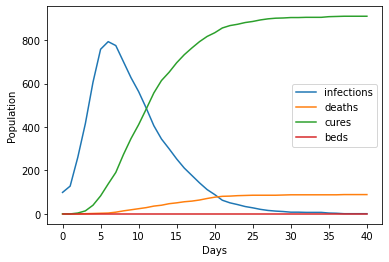

Days for survival 42
Casualties 76
Cures 924
Max Quarantine Beds used 0


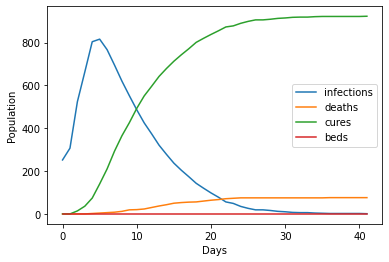

Days for survival 40
Casualties 77
Cures 923
Max Quarantine Beds used 0


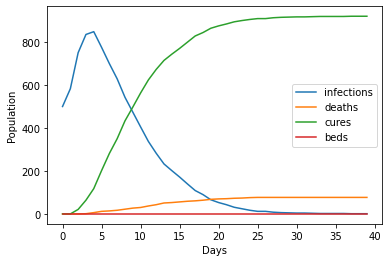

In [11]:
simulate(CovidSimulationModel(probability=0.1))
simulate(CovidSimulationModel(probability=0.25))
simulate(CovidSimulationModel(probability=0.50))

### Basic Simulation

1. When does the simulation stabilize?
    
    It can be seen that the simulation stabilizes when the cures, infections and death become a flat line and when there are no infected agents in space. We notice that on average we get the following values
    
| Probability | Days | Deaths | Cures |
| --- | --- | --- | --- |
| 0.1 | 44 | 78 | 877 |
| 0.25 | 43 | 80 | 919 |
| 0.5 | 41 | 86 | 917 |
   
            Above table has been generated after taking the mean of the values after 30 such simulations
   
   
2. Time taken to stabilize

    We see that as the percent of initially infected people increases, the number of days before the curve stabilizes tends to decrease as each day the agent goes through the transformation. And if lots of agents are already affected by the virus, they may undergo the transformation to the final state of diseased/ cured sooner. Corresponding values have been tablulated above.
    

3. When was the infection at its peak?

    When the initial infection was less, the peak new cases was between days 5 and 10. However, when the number of initially infected agents increased, we notice that the peak new cases in a day was hit much sooner. We also notice that the peak gets reached in 3 to 4 days as the percent of initial infections increases.


4. Deaths by the virus
    
    Since there are only 7 places the agents go to, there is a good chance that he/she gets affected. This makes the chance of death high. From mltiple runs of the simulations, we notice that on average there is a death rate of about 0.08 percent as mentioned in the table above.


5. Graphs

    Please find above the graphs for the probability values 0.1, 0.25 and 0.5 along with the metrics above the description

Days for survival 50
Casualties 65
Cures 933
Max Quarantine Beds used 74


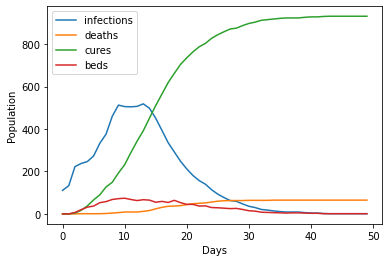

Days for survival 43
Casualties 67
Cures 933
Max Quarantine Beds used 82


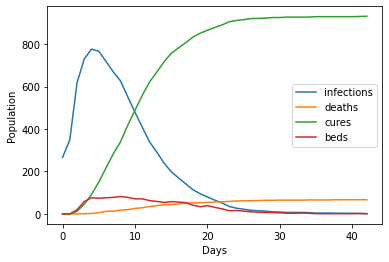

Days for survival 38
Casualties 80
Cures 920
Max Quarantine Beds used 76


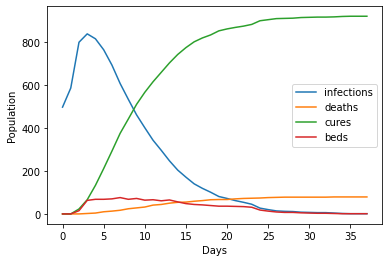

In [14]:
simulate(CovidSimulationModel(probability=0.1, quarantine=True))
simulate(CovidSimulationModel(probability=0.25, quarantine=True))
simulate(CovidSimulationModel(probability=0.50, quarantine=True))

### Adding Quarantine Centers

1. When does the simulation stabilize?
       
    It can be seen that the simulation stabilizes when the cures, infections and death become a flat line and when there are no infected agents in space. We notice that on average we get the following values
    
| Probability | Days | Deaths | Cures |
| --- | --- | --- | --- |
| 0.1 | 44 | 76 | 889 |
| 0.25 | 42 | 79 | 917 |
| 0.5 | 41 | 81 | 918 |
   
            Above table has been generated after taking the mean of the values after 30 such simulations
   


2. Time taken to stabilize

    Just like the previous case, we see that as the percent of infected people increases, the time to stabilize the virus decreases. Since we are working with a smaller dataset, we donot see a drastic decrease in the number of days. However, we can conclude that there is an appreciable increase in time as the initial infected percentage decreases. Values are mentioned in the table above.


3. When was the infection at its peak?
        
    With the quarentine in place, we actually notice that on average for an initial infected value of 0.1, the peak is reached only between 10 and 15 days and with an increase in this value to 0.5 the peak is reached between 5 and 10 days.
    
    
4. Deaths by the virus

    We notice that the deaths are not affected by the addition of quarantine. Considering the fact that we are running the simulation on 1000 agents, we could maybe say 76 deaths when 0.1 are affected is low in comparison to 82 when 0.25 of the population is affected. When scaline this up, the difference may prove to be huge.
    

5. Graphs
    
    Please find above the graphs for the probability values 0.1, 0.25 and 0.5 along with the metrics above the description
    
    
6. Quarantine center fill-up

    The Quarantine center doesnt seem to fill up for all the cases as the probability of an agent being in a critical stage is low. But we notice a steady increase in the number of occupied beds in the quarantine center to slowly increase as the number of initial infected agents increases.
    

Days for survival 65
Casualties 88
Cures 909
Max Quarantine Beds used 81


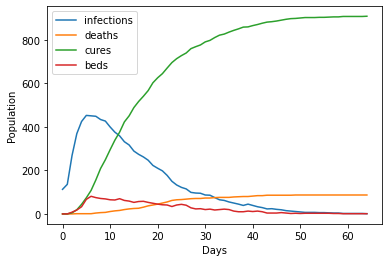

Days for survival 59
Casualties 74
Cures 914
Max Quarantine Beds used 76


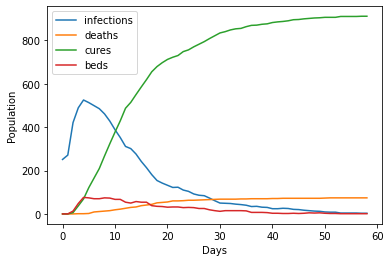

Days for survival 78
Casualties 79
Cures 919
Max Quarantine Beds used 79


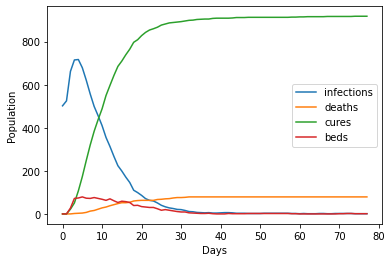

In [8]:
simulate(CovidSimulationModel(probability=0.1, quarantine=True, social_distance=True))
simulate(CovidSimulationModel(probability=0.25, quarantine=True, social_distance=True))
simulate(CovidSimulationModel(probability=0.50, quarantine=True, social_distance=True))

### Enforcing Social Distancing Norms

1. When does the simulation stabilize?
       
    It can be seen that the simulation stabilizes when the cures, infections and death become a flat line and when there are no infected agents in space. We notice that on average we get the following values
    
| Probability | Days | Deaths | Cures |
| --- | --- | --- | --- |
| 0.1 | 74 | 79 | 916 |
| 0.25 | 75 | 82 | 914 |
| 0.5 | 66 | 82 | 914 |

            Above table has been generated after taking the mean of the values after 30 such simulations
   
   
2. Time taken to stabilize

    Unlike the previous cases, we see that the stabilization time is much higher. We could thus say that social distancing may indeed help reach a virus free world but it does so by flattenning the peak across multiple days.


3. When was the infection at its peak?
        
    With the quarentine and social distancing in place, we see that on average for an initial infected value of 0.1, the peak is reached between 10 and 15 days and with an increase in this value to 0.5 the peak is reached between 5 and 10 days just like the previous situation with just quarantine. This is because of our tiny population and regions.
    
    
4. Deaths by the virus

    We notice that the deaths are also not affected by social distancing as the average number of fatalties is aroung 79 for initial probability of 0.1 and it tends to increase with a higher initial infected percentage. All values are tabulated above.
    

5. Graphs
    
    Please find above the graphs for the probability values 0.1, 0.25 and 0.5 along with the metrics above the description
    
    
6. Improvements in the situations?

    We could argue that with the addition of social distancing, we notice a much lower peak but a broader graph. This is mainly because we were able to prevent overcrowded quarantine centers with agents rushing to the quarantine centers but instead spreads the time at which each agent is affected so that resources can be efficiently managed.

## Conclusions

__Interesting findings__

If one looks at the three tables generated for the 3 situatuations ( Basic, Quarantine and Social Norms) we can justify that a similar number of agents reach a cured/ fatal stage but there is a huge difference in time taken to reach the final state. There is lesser unpredictability in the Graph with social distancing incorporated as the slope is much lesser than that determined in basic simulation and a broader graph helps the government manage resources. 

From Dr. Fauci's comments that "social distancing may decrease deaths in the country", we notice that that is not the case in our simulation. The reason for that is mainly because we start with about a 100 agents infected and we place on average a minimum of 30 of them in 7 areas. This makes a large number of asymptomatic individuals present in these hotspots negating the affect of quarantine and social distancing. When we change the probability of symptomatic agents to quarantine at home, the new generated graphs showed a decrease in daily deaths.


__Impacts of quarantine and Social distancing__

We could make a case that quarantine and social distancing definitely helps. In our simulations, since we have just 7 areas the agent may go to and since we have simplified the case of when he/she might get affected, we do not see a big difference in the time taken to reach a COVID free state. However, with social distancing in place as lesser people catch the virus sooner, there is a safe and efficient way in which the government could manage the situation.

Other things to note about quarantine and social distancing is that the beds occupied are filled more gradually when social distancing is added. 


__2 influential factors in spreading the virus__

1. The population of the region
2. How strictly the rules are followed


__Changes to society__

1. Minimal outdoor movement
2. Increased virtual events so that there as lesser crowds
3. More stricter social distancing norms

Ref: https://mesa.readthedocs.io/en/master/tutorials/intro_tutorial.html